<a href="https://colab.research.google.com/github/HyeongChanHam/Lung_Cancer_detection/blob/master/U_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import random
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.io import imread, imshow

from tqdm import tqdm

from skimage.transform import resize

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
PATH = "gdrive/My Drive/lung_cancer/"

In [0]:
img_path = PATH+'image/'
label_path = PATH+'mask/'

In [0]:
img_ids = next(os.walk(img_path))[2]
label_ids = next(os.walk(label_path))[2]
img_ids.sort()
label_ids.sort()
print(len(img_ids))
print(len(label_ids))

742
742


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


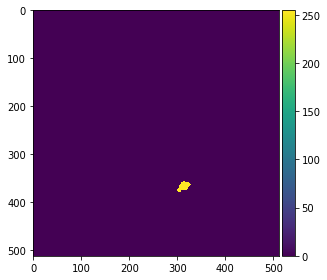

In [0]:
img = imread(img_path + img_ids[0])
imshow(img)
label = imread(label_path + label_ids[0])
imshow(label)

In [0]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1

In [0]:
X_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(img_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(img_ids), total=len(img_ids)):
    path = img_path + id_
    img = np.expand_dims(imread(path),axis=2)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

for n, id_ in tqdm(enumerate(label_ids), total=len(label_ids)):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.bool)
    path = label_path + id_
    label = np.expand_dims(imread(path), axis=2)
    mask = resize(label, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    Y_train[n] = mask

X_train = (X_train - X_train.mean()) / X_train.std()

Getting and resizing train images and masks ... 


100%|██████████| 742/742 [00:11<00:00, 64.47it/s]


image_LIDC-IDRI-0027_3_1.png


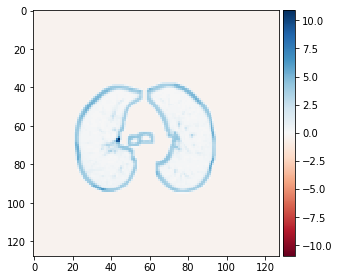

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


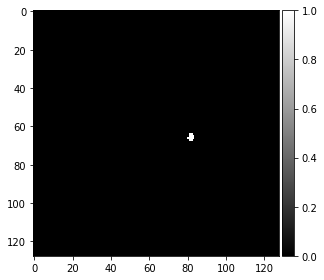

In [224]:
ix = random.randint(0, len(img_ids))
print(img_ids[ix])
imshow(X_train[ix][:,:,0])
plt.show()
imshow(Y_train[ix][:,:,0],cmap=plt.cm.gray)
plt.show()

In [0]:
# Define IoU metric
from keras import backend as K
# def iou(y_true, y_pred):
#     y_true = tf.cast(y_true, tf.bool)
#     intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
#     union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
#     iou = (intersection) / (union)
#     return iou


# def iou_loss(y_true, y_pred):
#     intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
#     union = K.sum(y_true, -1) + K.sum(y_pred, -1) - intersection
#     iou = (intersection) / (union)
#     return -iou

def iou(y_true, y_pred):
    intersection = (y_true[:,:,0]*y_pred[:,:,0]).sum()
    union =y_true[:,:,0].sum() + y_pred[:,:,0].sum() - intersection
    return intersection/union



# def iou(y_true, y_pred):
#     intersection = tf.reduce_sum(y_true[:,:,0]*y_pred[:,:,0])
#     union =tf.reduce_sum(y_true[:,:,0]) + tf.reduce_sum(y_pred[:,:,0]) - intersection
#     return intersection/union

In [0]:
# print(mean/_iou(Y_train[0], Y_train[0]))
for i in range(10):
    fig, ax = plt.subplots(1,2,figsize=(5,3))
    ax[0].imshow((Y_train[0] * Y_train[i])[:,:,0])
    # plt.show()
    ax[0].title.set_text(i)
    ax[1].imshow((Y_train[0] + Y_train[i])[:,:,0])
    # plt.show()
    intersection = (Y_train[0] * Y_train[i]).sum()
    union = (Y_train[0].sum()) + (Y_train[i].sum()) - intersection
    ax[1].title.set_text(intersection/union)
    plt.show()

In [0]:
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint


inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
adam = Adam(lr = 0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[iou])

model.summary()

In [225]:
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2020-4.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 667 samples, validate on 75 samples
Epoch 1/50
667/667 [==============================] - 122s 183ms/step - loss: 0.0158 - iou: 7.0607e-06 - val_loss: 0.0145 - val_iou: 2.1387e-06

Epoch 00001: val_loss improved from inf to 0.01454, saving model to model-dsbowl2020-4.h5
Epoch 2/50
667/667 [==============================] - 121s 181ms/step - loss: 0.0114 - iou: 2.6346e-05 - val_loss: 0.0102 - val_iou: 4.8522e-05

Epoch 00002: val_loss improved from 0.01454 to 0.01022, saving model to model-dsbowl2020-4.h5
Epoch 3/50
667/667 [==============================] - 125s 187ms/step - loss: 0.0102 - iou: 5.4946e-05 - val_loss: 0.0114 - val_iou: 3.2514e-05

Epoch 00003: val_loss did not improve from 0.01022
Epoch 4/50
667/667 [==============================] - 120s 179ms/step - loss: 0.0079 - iou: 3.6444e-04 - val_loss: 0.0115 - val_iou: 3.6403e-04

Epoch 00004: val_loss did not improve from 0.01022
Epoch 5/50
667/667 [==============================] - 122s 183ms/step - loss: 0.0055 - io

In [0]:
#model-dsbowl2018-1.h5 download
from google.colab import files
files.download('model-dsbowl2020-4.h5')

In [237]:
# Predict on train, val and test
model = load_model('model-dsbowl2020-4.h5', custom_objects={'iou':iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

75/75 [==============================] - 3s 43ms/step


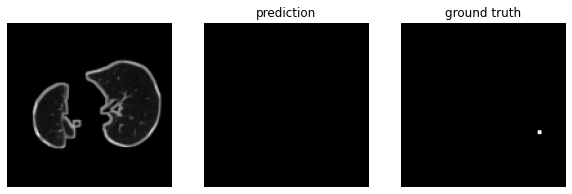

iou :  0.0


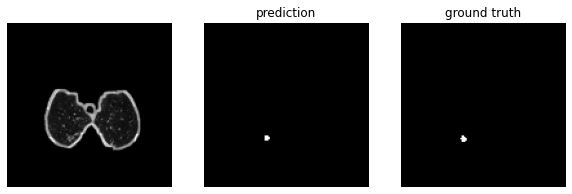

iou :  0.631578947368421


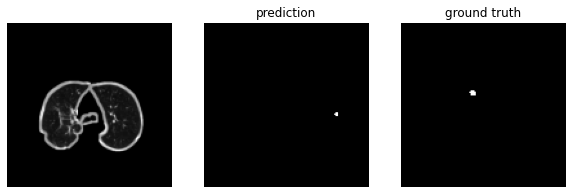

iou :  0.0


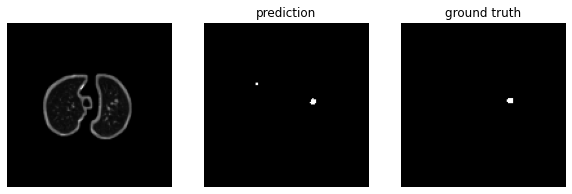

iou :  0.5


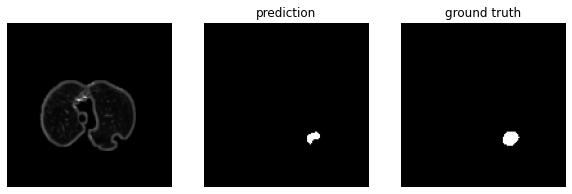

iou :  0.5412844036697247


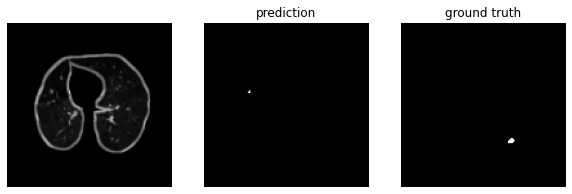

iou :  0.0


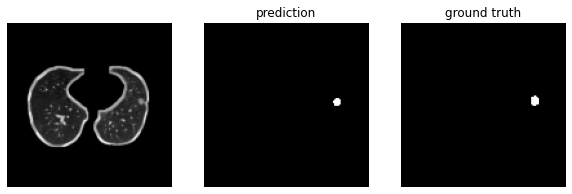

iou :  0.6046511627906976


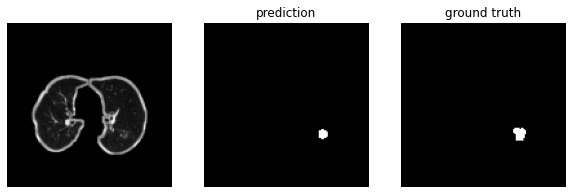

iou :  0.5714285714285714


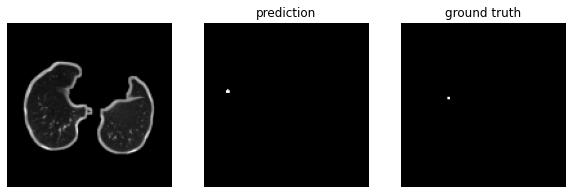

iou :  0.0


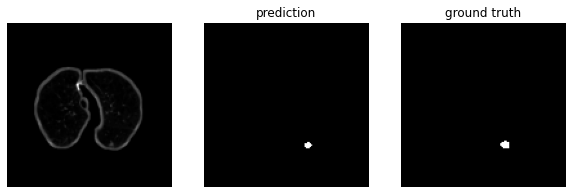

iou :  0.6363636363636364
[0.75       0.87356322 0.88541667 0.80733945 0.84158416 0.83870968
 0.84705882 0.75342466 0.36111111 0.45       0.82758621 0.8
 0.74666667 0.83950617 0.8902439  0.89156627 0.85882353 0.80487805
 0.74025974 0.78571429 0.58139535 0.6984127  0.76923077 0.75
 0.70588235 0.75       0.65517241 0.44444444 0.4        0.59183673
 0.72727273 0.79166667 0.79591837 0.75438596 0.76271186 0.84
 0.         0.         0.70967742 0.6031746  0.57142857 0.63380282
 0.73076923 0.85365854 0.52       0.68852459 0.7761194  0.86363636
 0.84507042 0.82608696 0.86206897 0.         0.         0.
 0.         0.56       0.75862069 0.64705882 0.4516129  0.
 0.         0.         0.0625     0.69565217 0.64285714 0.67307692
 0.72131148 0.76923077 0.78205128 0.79069767 0.82022472 0.78205128
 0.61764706 0.51219512 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.   

In [248]:
iou_vec = np.array([])
for i in range(10):
    ix = random.randint(0, len(preds_train_t))
    fig, ax = plt.subplots(1,3,figsize=(10,6))
    ax[0].imshow(X_train[ix][:,:,0],cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(np.squeeze(preds_train_t[ix][:,:,0]),cmap='gray')
    ax[1].title.set_text("prediction")
    ax[1].axis('off')
    ax[2].imshow(np.squeeze(Y_train[ix][:,:,0]),cmap='gray')
    ax[2].title.set_text("ground truth")
    ax[2].axis('off')
    plt.show()
    print("iou : ",iou(preds_train_t[ix].astype(np.bool),Y_train[ix]))
    # print(preds_train_t[ix].astype(np.bool).shape)
    # preds_train_t[ix].astype(np.bool) + 
for i in range(len(preds_train_t)):
    iou_vec = np.append(iou_vec, iou(preds_train_t[i].astype(np.bool),Y_train[i]))
print(iou_vec)
print(iou_vec.mean())

In [250]:
np.where(iou_vec>0,1,0).mean()

0.5967016491754122